In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
import re
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
random.seed(2006)

ModuleNotFoundError: No module named 'lightgbm'

In [2]:
train_data = pd.DataFrame(pd.read_csv('jinnan_round1_train_20181227.csv',encoding='gb2312'))
test_data = pd.DataFrame(pd.read_csv('jinnan_round1_testB_20190121.csv',encoding='gb2312'))

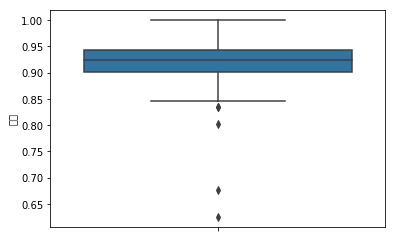

In [3]:
sns.boxplot(y=train_data['收率'])

In [4]:
train_data = train_data[train_data['收率'] > 0.85]
train_data = train_data[train_data['收率'] <= 1]
test_data['收率'] = np.nan
data = pd.concat([train_data,test_data]).reset_index(drop=True)

In [5]:
# 特征统计
def feature_num(data):
    stats = []
    for cols in data.columns:
        stats.append((cols, data[cols].nunique(), data[cols].isnull().sum(
        )*100/data.shape[0], data[cols].value_counts(normalize=True, dropna=False).values[0]*100, data[cols].dtype))
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values',
                                            'Percentage of values in the biggest category', 'type'])
    return stats_df.sort_values('Percentage of missing values', ascending=False)

In [6]:
# 将时间数据变为时间点数据
def timeTranSecond(t):
    try:
        t, m, s = t.split(":")
    except:
        if t == '1900/1/9 7:00':
            return 7*3600/3600
        elif t == '1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t == -1:
            return -1
        else:
            return None
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    return tm

# 将时间数据变为时间差数据
def getDuration(se):
    try:
        sh, sm, eh, em = re.findall(r"\d+\.?\d*", se)
    except:
        if se == -1:
            return -1
        else:
            return None
    try:
        if int(sh) > int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se == '19:-20:05':
            return 1
        elif se == '15:00-1600':
            return 1
    return tm

In [7]:
for cols in ['A5', 'A7', 'A9', 'A11', 'A14', 'A16', 'A24', 'A26', 'B5', 'B7']:
    try:
        data[cols] = data[cols].apply(timeTranSecond)
    except:
        print(cols, '不存在')
for cols in ['A20', 'A28', 'B4', 'B9', 'B10', 'B11']:
    data[cols] = data.apply(lambda df: getDuration(df[cols]), axis=1)

In [8]:
# 切分样本id作为特征
data['样本id'] = data['样本id'].map(lambda x: int(x.split('_')[1]))
data.head()
data = data.reset_index(drop=True)

In [9]:
# 特征离群点观察,对于可判断离群点进行删改
def feature_outles(data):
    # sns.scatterplot(data=data['B14'])
    data.loc[data['B14'] == 785,'B14'] = 385
    data.loc[data['B14'] == 40,'B14'] = 400
    # B14特征中三个离群点，785-385,40-400
    # sns.scatterplot(data=data['B13'])
    # B11字段的离群点是时间记录错误，无法推断出正确的时间，所以使用Nan值填充
    # sns.scatterplot(data=data['B11'])
    data.loc[data['B11']>10,'B11']
    # 观察B10的特征值，去除异常点
    #sns.scatterplot(data=data['B10'])
    data.loc[data['B10']>10,'B10'] = np.nan
    # 观察B9的特征异常点
    #sns.scatterplot(data=data['B9'])
    data.loc[data['B9']>4,'B9'] = np.nan
    # B4特征
    #sns.scatterplot(data=data['B4'])
    data.loc[data['B4']>10,'B4'] = np.nan
    # B1特征
    #sns.scatterplot(data=data['B1'])
    data.loc[data['B1']<10,'B1'] = np.nan
    # A28
    #sns.scatterplot(data=data['A28'])
    data.loc[data['A28']>5,'A28'] = np.nan
    # A25
    data.loc[data['样本id']==1590,'A25'] = np.nan
    data['A25'] = data['A25'].astype('float')
    #sns.scatterplot(data=data['A25'])
    # A22
    #sns.scatterplot(data=data['A22'])
    data.loc[data['A22'] < 4, 'A22'] = np.nan
    # A20
    #sns.scatterplot(data=data['A20'])
    data.loc[data['A20'] > 10, 'A20'] = np.nan
    return data
data = feature_outles(data)

In [10]:
feature_num(data)
data.to_csv('processing_data.csv',index=None)

In [11]:
# 构建新的特征
data['B14/A1_A3_A4_A19_B1_B12'] = data['B14'] / \
    (data['A1']+data['A3']+data['A4']+data['A19']+data['B1']+data['B12'])#B14与所有原料的比
data['A19+B1/B14'] = (data['A19']+data['B1'])/(data['B14'])#盐酸和B14的比
data['A17-A6/A16-A5'] = (data['A17']-data['A6'])/((data['A16'] - data['A5']).map(lambda x: x if x > 0 else x+24))# 一段反应时间的温度和时间变化比
data['A27-A25/A26'] = (data['A27']-data['A25'])/data['A26']#重复加料最后的温度差与时间比，反应速率
data['A10/12/15/17_std'] = data.loc[:,['A10', 'A12', 'A15', 'A17']].std(axis=1)#反应不同阶段的温度差
# drop_cols = ['A1', 'A2', 'A3', 'A4', 'A8', 'A13', 'A18', 'A19',
#              'A20', 'A21','A22', 'A23', 'A28', 'B2', 'B3', 'B4', 'B12', 'B13','B8','A10','A12','A15','A17']
# data.drop(drop_cols, axis=1, inplace=True)
data.shape

(1538, 49)

In [12]:
train_data = data.loc[data['收率'] > 0,:]
test_data = data.iloc[train_data.shape[0]:,:].reset_index(drop=True)
del test_data['收率']
target = train_data['收率']
del train_data['收率']
print(train_data.shape,test_data.shape)

(1389, 48) (149, 48)


In [13]:
# 画出特征重要性
def plt_importtance(model):
    ft, ax = plt.subplots(figsize=(8, 8))
    lgb.plot_importance(
        model, grid=True, max_num_features=50, ax=ax, height=0.8)
    plt.title("Featurertances")
    plt.show()

In [14]:
def lgb_model(train_data, target, seed=2006):
    x_train, x_test, y_train, y_test = train_test_split(
        train_data, target, test_size=0.33, random_state=seed)
    train_data = lgb.Dataset(x_train, y_train)
    test_data = lgb.Dataset(x_test, y_test)
    params = {'num_leaves': 20,
              'min_data_in_leaf': 10,
              'objective': 'regression',
              'max_depth': 3,
              'learning_rate': 0.015,
              "min_child_samples": 30,
              "boosting": "gbdt",
              "feature_fraction": 0.9,
              "bagging_fraction": 0.9,
              "metric": 'mse'}
    model = lgb.train(train_set=train_data, valid_sets=test_data, params=params,
                      num_boost_round=2000, early_stopping_rounds=100)
    return model

In [15]:
model = lgb_model(train_data,target)

[1]	valid_0's l2: 0.0007331
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 0.00071724
[3]	valid_0's l2: 0.00070186
[4]	valid_0's l2: 0.000686945
[5]	valid_0's l2: 0.00067314
[6]	valid_0's l2: 0.000660963
[7]	valid_0's l2: 0.000647256
[8]	valid_0's l2: 0.000633965
[9]	valid_0's l2: 0.000621076
[10]	valid_0's l2: 0.000608579
[11]	valid_0's l2: 0.00059646
[12]	valid_0's l2: 0.000584587
[13]	valid_0's l2: 0.000573204
[14]	valid_0's l2: 0.000562031
[15]	valid_0's l2: 0.000552661
[16]	valid_0's l2: 0.000542469
[17]	valid_0's l2: 0.000532317
[18]	valid_0's l2: 0.000522821
[19]	valid_0's l2: 0.000513518
[20]	valid_0's l2: 0.000504238
[21]	valid_0's l2: 0.000495241
[22]	valid_0's l2: 0.000486875
[23]	valid_0's l2: 0.00047884
[24]	valid_0's l2: 0.000471105
[25]	valid_0's l2: 0.000463558
[26]	valid_0's l2: 0.000456701
[27]	valid_0's l2: 0.000449371
[28]	valid_0's l2: 0.000442011
[29]	valid_0's l2: 0.000434835
[30]	valid_0's l2: 0.000428575
[31]	valid_0's l2: 0.00

[291]	valid_0's l2: 0.00013377
[292]	valid_0's l2: 0.000133566
[293]	valid_0's l2: 0.000133522
[294]	valid_0's l2: 0.000133407
[295]	valid_0's l2: 0.000133295
[296]	valid_0's l2: 0.00013317
[297]	valid_0's l2: 0.000133028
[298]	valid_0's l2: 0.00013283
[299]	valid_0's l2: 0.00013242
[300]	valid_0's l2: 0.00013238
[301]	valid_0's l2: 0.000132261
[302]	valid_0's l2: 0.000132247
[303]	valid_0's l2: 0.000132133
[304]	valid_0's l2: 0.000131739
[305]	valid_0's l2: 0.000131525
[306]	valid_0's l2: 0.000131368
[307]	valid_0's l2: 0.0001309
[308]	valid_0's l2: 0.000130686
[309]	valid_0's l2: 0.000130403
[310]	valid_0's l2: 0.000130242
[311]	valid_0's l2: 0.000130197
[312]	valid_0's l2: 0.0001301
[313]	valid_0's l2: 0.000129756
[314]	valid_0's l2: 0.00012975
[315]	valid_0's l2: 0.000129624
[316]	valid_0's l2: 0.000129596
[317]	valid_0's l2: 0.000129563
[318]	valid_0's l2: 0.000129381
[319]	valid_0's l2: 0.000129332
[320]	valid_0's l2: 0.000129291
[321]	valid_0's l2: 0.000129033
[322]	valid_0's l2

[561]	valid_0's l2: 0.000114765
[562]	valid_0's l2: 0.000114766
[563]	valid_0's l2: 0.000114742
[564]	valid_0's l2: 0.000114693
[565]	valid_0's l2: 0.000114651
[566]	valid_0's l2: 0.000114672
[567]	valid_0's l2: 0.000114673
[568]	valid_0's l2: 0.000114651
[569]	valid_0's l2: 0.000114649
[570]	valid_0's l2: 0.000114624
[571]	valid_0's l2: 0.000114624
[572]	valid_0's l2: 0.000114609
[573]	valid_0's l2: 0.000114559
[574]	valid_0's l2: 0.000114555
[575]	valid_0's l2: 0.000114534
[576]	valid_0's l2: 0.000114506
[577]	valid_0's l2: 0.000114487
[578]	valid_0's l2: 0.00011449
[579]	valid_0's l2: 0.000114356
[580]	valid_0's l2: 0.000114318
[581]	valid_0's l2: 0.00011432
[582]	valid_0's l2: 0.000114334
[583]	valid_0's l2: 0.000114319
[584]	valid_0's l2: 0.000114274
[585]	valid_0's l2: 0.0001143
[586]	valid_0's l2: 0.000114298
[587]	valid_0's l2: 0.000114252
[588]	valid_0's l2: 0.000114275
[589]	valid_0's l2: 0.000114275
[590]	valid_0's l2: 0.000114266
[591]	valid_0's l2: 0.000114245
[592]	valid_

[899]	valid_0's l2: 0.000110298
[900]	valid_0's l2: 0.00011031
[901]	valid_0's l2: 0.000110264
[902]	valid_0's l2: 0.00011026
[903]	valid_0's l2: 0.00011025
[904]	valid_0's l2: 0.000110219
[905]	valid_0's l2: 0.000110211
[906]	valid_0's l2: 0.000110167
[907]	valid_0's l2: 0.000110177
[908]	valid_0's l2: 0.000110174
[909]	valid_0's l2: 0.000110092
[910]	valid_0's l2: 0.000110118
[911]	valid_0's l2: 0.000110125
[912]	valid_0's l2: 0.000110098
[913]	valid_0's l2: 0.000110091
[914]	valid_0's l2: 0.000110084
[915]	valid_0's l2: 0.000110095
[916]	valid_0's l2: 0.000110122
[917]	valid_0's l2: 0.000110127
[918]	valid_0's l2: 0.000110139
[919]	valid_0's l2: 0.000110145
[920]	valid_0's l2: 0.0001101
[921]	valid_0's l2: 0.000110087
[922]	valid_0's l2: 0.000110062
[923]	valid_0's l2: 0.000110032
[924]	valid_0's l2: 0.000110042
[925]	valid_0's l2: 0.000110024
[926]	valid_0's l2: 0.00011003
[927]	valid_0's l2: 0.000110033
[928]	valid_0's l2: 0.000109985
[929]	valid_0's l2: 0.000109987
[930]	valid_0'

[1154]	valid_0's l2: 0.000109164
[1155]	valid_0's l2: 0.000109167
[1156]	valid_0's l2: 0.000109149
[1157]	valid_0's l2: 0.000109166
[1158]	valid_0's l2: 0.000109174
[1159]	valid_0's l2: 0.000109181
[1160]	valid_0's l2: 0.000109185
[1161]	valid_0's l2: 0.000109196
[1162]	valid_0's l2: 0.000109184
[1163]	valid_0's l2: 0.000109164
[1164]	valid_0's l2: 0.000109171
[1165]	valid_0's l2: 0.000109173
[1166]	valid_0's l2: 0.000109176
[1167]	valid_0's l2: 0.000109181
[1168]	valid_0's l2: 0.000109154
[1169]	valid_0's l2: 0.000109176
[1170]	valid_0's l2: 0.000109165
[1171]	valid_0's l2: 0.000109154
[1172]	valid_0's l2: 0.00010913
[1173]	valid_0's l2: 0.000109097
[1174]	valid_0's l2: 0.000109083
[1175]	valid_0's l2: 0.000109094
[1176]	valid_0's l2: 0.000109097
[1177]	valid_0's l2: 0.000109096
[1178]	valid_0's l2: 0.000109076
[1179]	valid_0's l2: 0.000109074
[1180]	valid_0's l2: 0.000109075
[1181]	valid_0's l2: 0.000109081
[1182]	valid_0's l2: 0.000109054
[1183]	valid_0's l2: 0.000109054
[1184]	vali

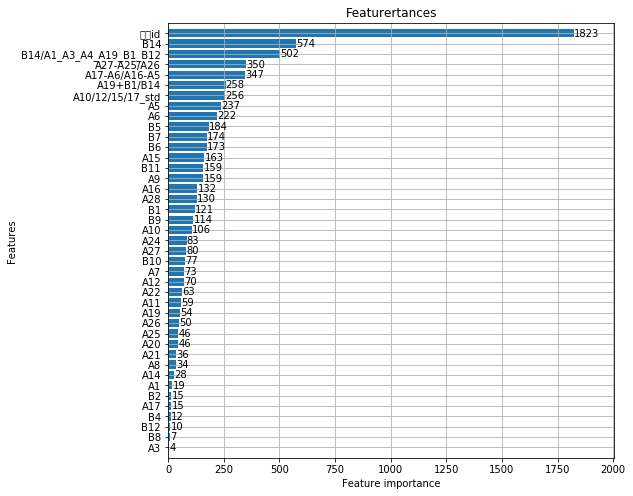

In [16]:
plt_importtance(model)

In [17]:
# 写入sub
test_result = pd.DataFrame(model.predict(test_data))
test_id = test_data['样本id'].map(lambda x: 'sample_'+str(x))
result = pd.concat([test_id,test_result],axis=1)
result.to_csv('sub_B.csv',header=None,index=None)